In [2]:
import torch
from tqdm import tqdm
from openstl.models.simvp_model import SimVP_Model
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
import torch.optim as optm
import os
from metrics import confusion_matrix, f1_score
import numpy as np
import torch.nn.functional as F
from torchsummary import summary

from BaseExperiment import _build_model

from osgeo import gdal

/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_tif_image(tif_path):
    gdal_header = gdal.Open(str(tif_path))
    return gdal_header.ReadAsArray()

In [3]:
batch_size = 32
custom_training_config = {
    'pre_seq_length': 2,
    'aft_seq_length': 1,
    'total_length': 3,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 100,
    'lr': 1e-4,
    # 'metrics': ['mse', 'mae', 'acc', 'Recall', 'Precision', 'f1_score', 'CM'],
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp03', # custom_exp
    'dataname': 'custom',
    'in_shape': [2, 1, 98, 136], # T, C, H, W = self.args.in_shape
    'patience': 10,
    'delta': 0.001,
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 2,
    'N_T': 2,
    'hid_S': 32, # default: 64
    'hid_T': 128 # default: 256
}

device = "cuda:0"
work_dir_path = os.path.join('work_dirs', custom_training_config['ex_name'])
model = _build_model(custom_training_config['in_shape'], None, custom_model_config, device)
model.load_state_dict(torch.load(os.path.join(work_dir_path, 'checkpoint.pth')))

32 128
[False, True]


<All keys matched successfully>

In [4]:
imgs_lst = ['data/IBAMA/25K/Geotiff-INPE/tiffs/ArCS010720.tif', 'data/IBAMA/25K/Geotiff-INPE/tiffs/ArCS160720.tif',
            'data/IBAMA/25K/Geotiff-INPE/tiffs/ArCS010820.tif', 'data/IBAMA/25K/Geotiff-INPE/tiffs/ArCS160820.tif']

In [20]:
mean = 0.00870167
std = 0.30169973
# for img_name in imgs_lst:
img1 = load_tif_image(imgs_lst[0])
img2 = load_tif_image(imgs_lst[1])
img = np.stack([img1, img2], axis=0)
print(img.shape)
img = torch.tensor(img).unsqueeze(1).to(device)
print(img.shape)
img[img < -1e38] = 0
img_norm = (img - mean) / std
with torch.no_grad():
    pred = model(img_norm.unsqueeze(0))
    print(pred.shape)

(2, 98, 136)
torch.Size([2, 1, 98, 136])
torch.Size([1, 2, 1, 98, 136])


(1, 98, 136)
tensor(1.7541, device='cuda:0') tensor(-1.6599, device='cuda:0')


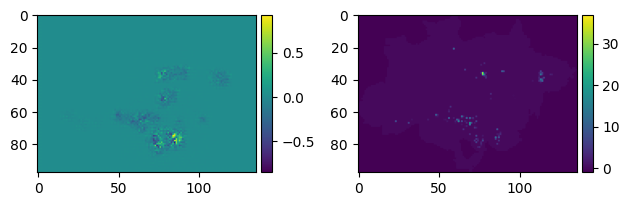

In [28]:
# Plot pred and img_lst[2] side by side
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2)
print(pred[0, 0].cpu().numpy().shape)
im1 = ax[0].imshow(pred[0, 0, 0].cpu().numpy())
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax)
print(pred.max(), pred.min())

label = load_tif_image(imgs_lst[2])
label[label < -1e38] = -1
im2 = ax[1].imshow(label)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax)
plt.tight_layout()
plt.show()

fig.savefig("figure.png", dpi=300)

In [11]:
img_path = 'data/IBAMA/25K/INPE/tiff/nv20170801.tif'
img = load_tif_image(img_path)
print(img.shape)
print(img.max(), img.min())

(98, 136)
624.99994 -1.0


In [9]:
import geopandas as gpd
import rasterio

# # Replace 'your_file.tif' with the actual path to your TIFF file
# file_path = 'your_file.tif'

# Read the TIFF file using rasterio
with rasterio.open(img_path) as src:
    # Get the metadata (attributes) of the TIFF file
    tiff_metadata = src.meta

# Create a GeoDataFrame with the metadata
gdf = gpd.GeoDataFrame({'geometry': [src.bounds]})

# Print the GeoDataFrame
print(gdf)

# Print additional metadata from rasterio
print("Rasterio Metadata:")
print(tiff_metadata)


                                            geometry
0  (2795368.0772499945, 8138773.424522044, 619536...
Rasterio Metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 136, 'height': 98, 'count': 83, 'crs': CRS.from_epsg(5880), 'transform': Affine(25000.0, 0.0, 2795368.0772499945,
       0.0, -25000.0, 10588773.424522044)}
